As individual deadwood instances are not that useful as a final product, here we show how they can be further processed to more useful data.

# Data aggregated to Forest Centre stand level

In [1]:
from drone_detector.utils import * 
from drone_detector.imports import *
import warnings
warnings.filterwarnings("ignore")
sys.path.append('..')
from src.tree_functions import *
from tqdm.auto import tqdm
tqdm.pandas()
import seaborn as sns

Read files for stand data, borders for valid area in UAV imagery and full predictions.

In [9]:
spk_stands = gpd.read_file('../../data/evo/MV_Hämeenlinna/MV_Hämeenlinna.gpkg', layer='stand')
spk_borders = gpd.read_file('../../data/evo/sudenpesankangas/spk_valid.geojson')
spk_results = gpd.read_file('../../results/evo/sudenpesankangas/merged/spk_full_new.gpkg', layer='predictions')

Clip stand data to only contain relevant areas.

In [10]:
spk_stands = spk_stands.clip(spk_borders)

Attach tree length, diameter and volume to predictions.

In [11]:
spk_results['tree_length'] = spk_results.geometry.progress_apply(get_len)
spk_results['diam'] = spk_results.geometry.progress_apply(lambda row: np.mean(get_three_point_diams(row))) * 1000
spk_results['v_ddw'] = spk_results.geometry.progress_apply(cut_cone_volume)

  0%|          | 0/69165 [00:00<?, ?it/s]

  0%|          | 0/69165 [00:00<?, ?it/s]

  0%|          | 0/69165 [00:00<?, ?it/s]

Drop most obvious faulty groundwood detections (those with volume more than 5m³). These are for instance roads, gray rooftops etc.

In [12]:
spk_results.drop(spk_results[(spk_results.v_ddw > 5) & (spk_results.layer == 'groundwood')].index, inplace=True)

Check the total amounts of deadwood present.

In [13]:
spk_results.layer.value_counts()

groundwood     55679
uprightwood    13359
Name: layer, dtype: int64

Derive the following:

* `n_dw`: the number of deadwood instances per hectare
* `n_ddw`: the number of fallen deadwood instances per hectare
* `n_udw`: the number of standin gdeadwood instances per hectare
* `v_ddw`: the estimated volume of fallen deadwood per hectare

In [9]:
spk_stands['n_dw'] = spk_stands.progress_apply(lambda row: len(spk_results[spk_results.geometry.within(row.geometry)]) 
                                                           / row.area, axis=1)
spk_stands['n_ddw'] = spk_stands.progress_apply(lambda row: len(spk_results[(spk_results.geometry.within(row.geometry)) 
                                                                             & (spk_results.layer=='groundwood')]) 
                                                           / row.area, axis=1)
spk_stands['n_udw'] = spk_stands.progress_apply(lambda row: len(spk_results[(spk_results.geometry.within(row.geometry)) 
                                                                             & (spk_results.layer=='uprightwood')]) 
                                                           / row.area, axis=1)
spk_stands['v_ddw'] = spk_stands.progress_apply(lambda row: spk_results[(spk_results.geometry.within(row.geometry)) 
                                                                        & (spk_results.layer=='groundwood')].v_ddw.sum() 
                                                           / row.area, axis=1)

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

  0%|          | 0/526 [00:00<?, ?it/s]

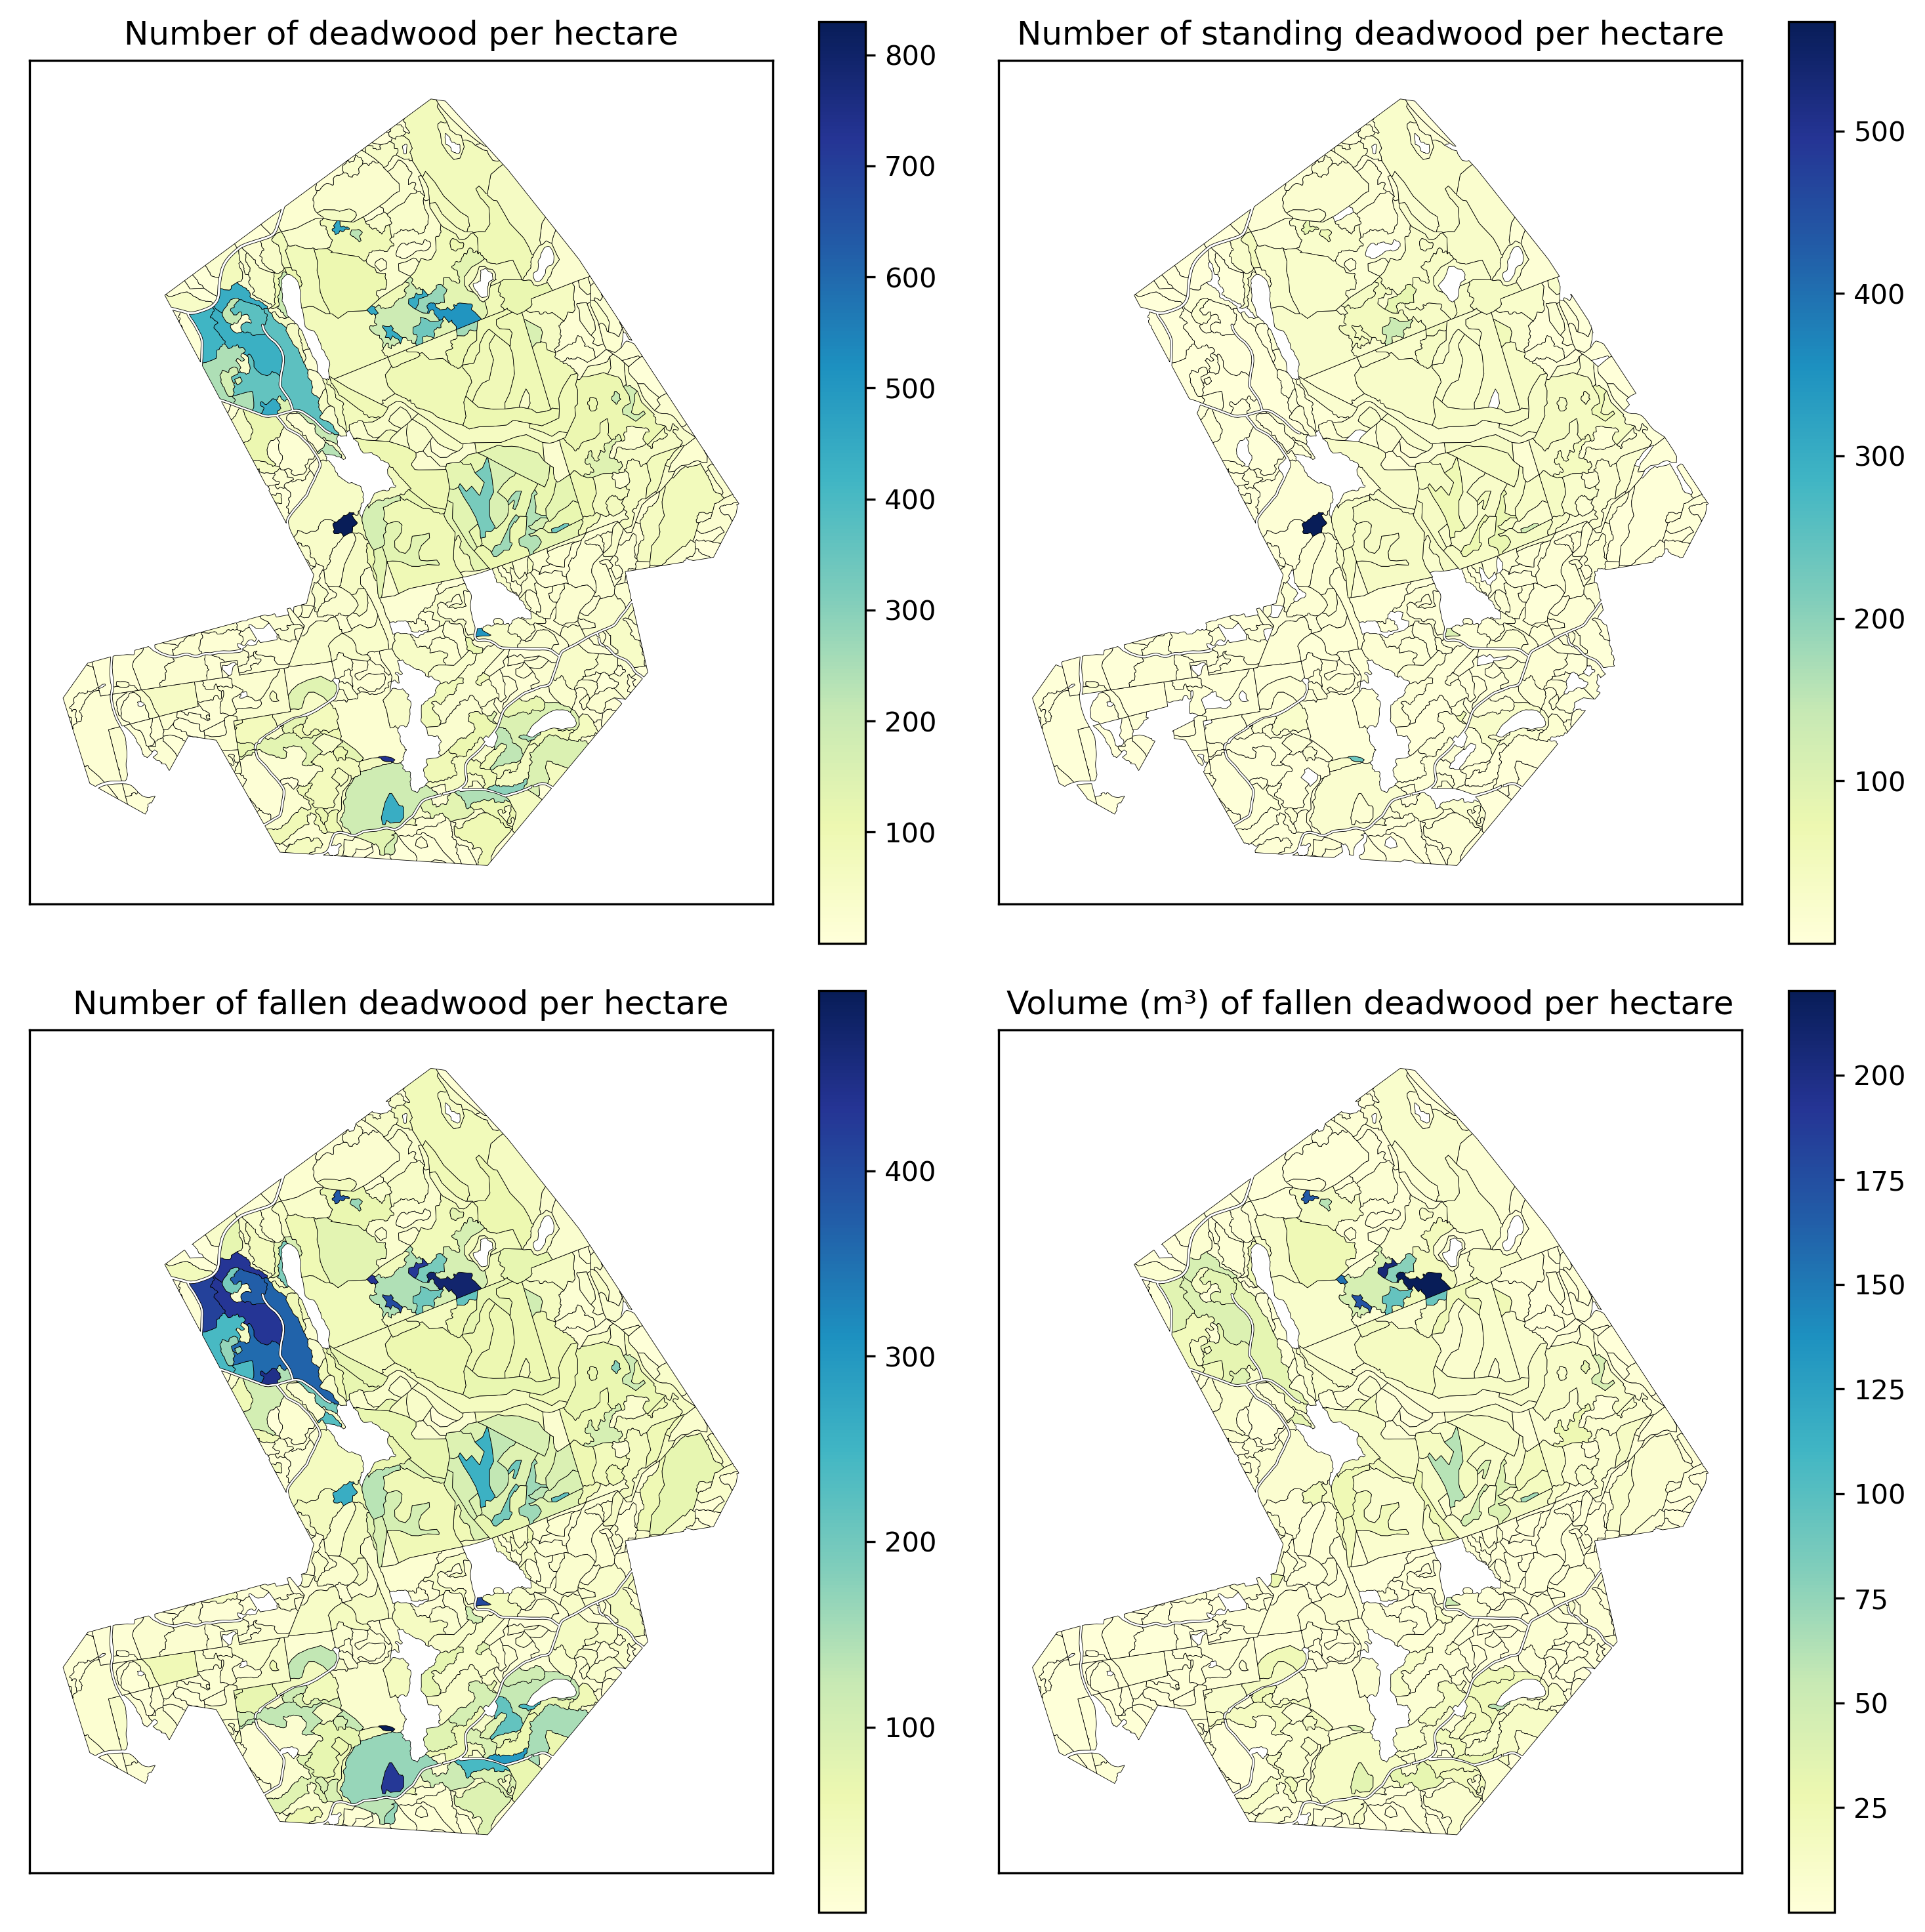

In [10]:
#| echo: false

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(2,2, dpi=300, figsize=(10,10))
spk_stands[spk_stands.n_dw > 0].plot(column='n_dw', legend=True, ax=ax[0,0], cmap='YlGnBu', 
                                     edgecolor='black', linewidth=.2,)
spk_stands[spk_stands.n_udw > 0].plot(column='n_udw', legend=True, ax=ax[0,1], cmap='YlGnBu', 
                                      edgecolor='black', linewidth=.2)
spk_stands[spk_stands.n_ddw > 0].plot(column='n_ddw', legend=True, ax=ax[1,0], cmap='YlGnBu', 
                                      edgecolor='black', linewidth=.2,)
spk_stands[spk_stands.v_ddw > 0].plot(column='v_ddw', legend=True, ax=ax[1,1], cmap='YlGnBu', 
                                      edgecolor='black', linewidth=.2)
ax[0,0].set_title('Number of deadwood per hectare')
ax[0,1].set_title('Number of standing deadwood per hectare')
ax[1,0].set_title('Number of fallen deadwood per hectare')
ax[1,1].set_title('Volume (m³) of fallen deadwood per hectare')
for a in ax.flatten():
    a.set_xticks([])
    a.set_yticks([])
plt.tight_layout()
#plt.savefig('../../figures/stand_metrics_evo.jpeg', dpi=300, bbox_inches='tight')
plt.show()

Better maps are done in QGis (use Jenks breaks).

Add information about conserved areas

In [38]:
protected_area = gpd.read_file('../../../../FEO/CDDA_2021_v01_public.gpkg', layer='ProtectedSite')
protected_area = protected_area[protected_area.siteName == 'Sudenpesänkankaan suojelualue']
protected_area = protected_area.to_crs(spk_stands.crs)
spk_stands['conservation'] = spk_stands.geometry.apply(lambda row: 1 if row.buffer(-1).within(protected_area.iloc[0].geometry)
                                                                   else 0)

Add stand-wise canopy density.

In [14]:
import rasterio.mask as rio_mask

pcts = []

with rio.open('../../data/evo/ChmEvo_norm.tif') as src:
    crs = src.crs
    for row in tqdm(spk_stands.itertuples()):
        plot_im, plot_tfm = rio_mask.mask(src, [box(*row.geometry.bounds)], crop=True)
        pcts.append(plot_im[plot_im > 2].shape[0] / plot_im[plot_im >= 0].shape[0])
spk_stands['canopy_cover_pct'] = pcts

0it [00:00, ?it/s]

See if any correlation can be seen for number of detected trees and canopy cover.

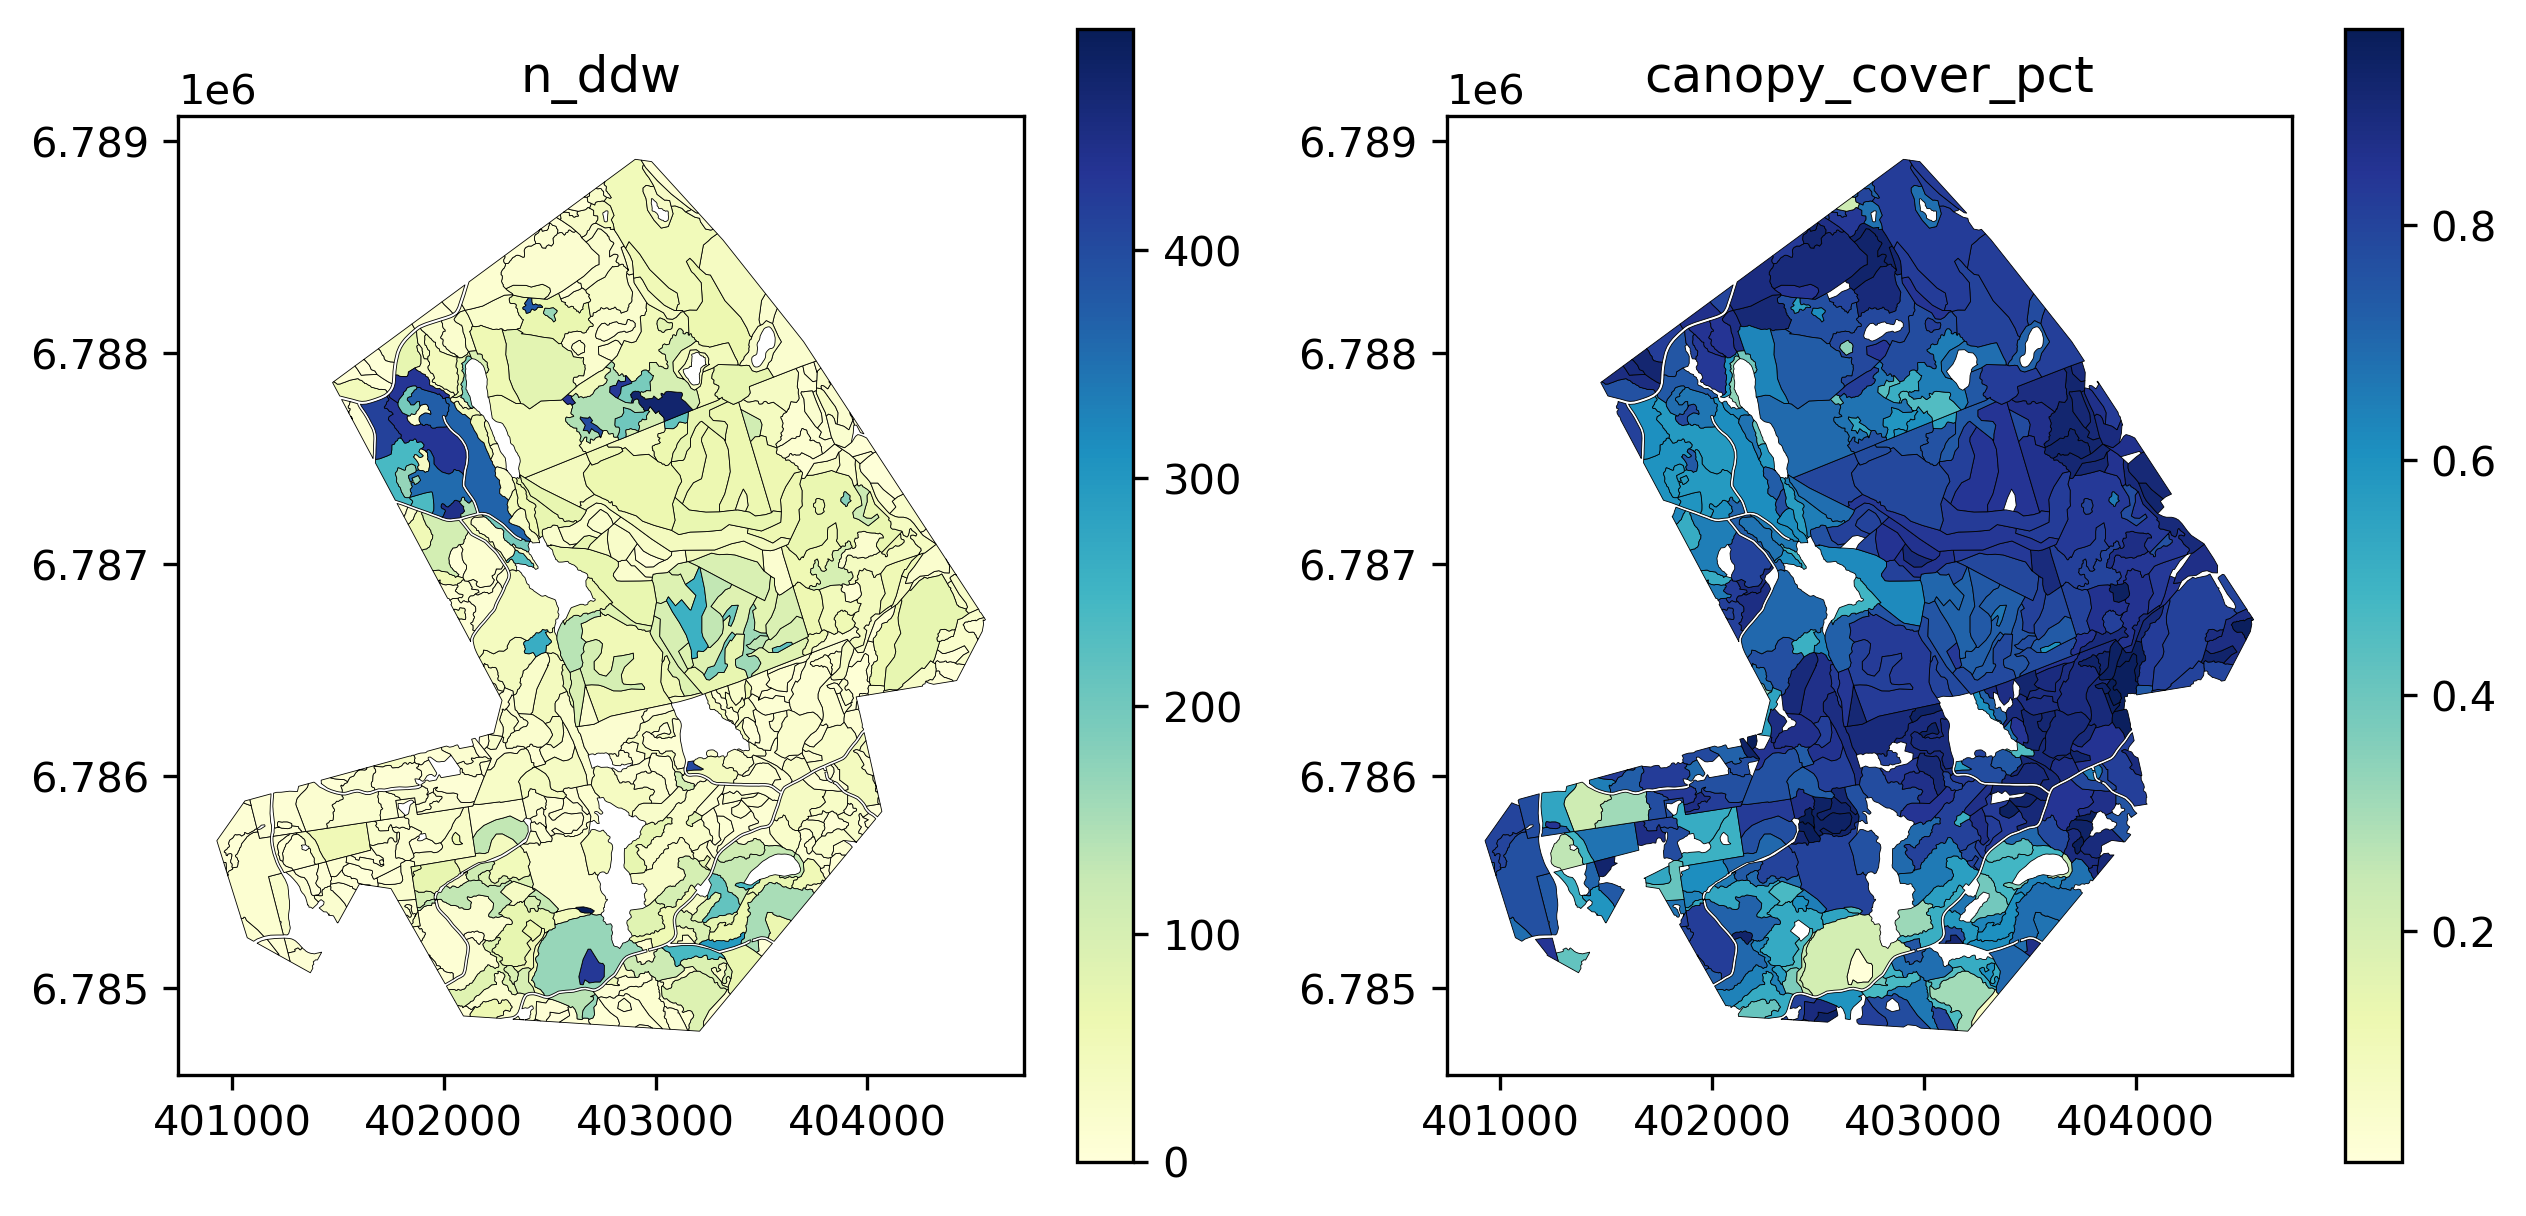

In [70]:
fig, ax = plt.subplots(1,2, dpi=300, figsize=(10,5))
spk_stands[spk_stands.n_dw > 0].plot(column='n_ddw', legend=True, ax=ax[0], cmap='YlGnBu', 
                                     edgecolor='black', linewidth=.2).set_title('n_ddw')
spk_stands[spk_stands.n_udw > 0].plot(column='canopy_cover_pct', legend=True, ax=ax[1], cmap='YlGnBu', 
                                      edgecolor='black', linewidth=.2).set_title('canopy_cover_pct')
plt.show()

Not much, aside for perhaps the areas in the upper-central stands.

Next see effect of canopy cover and different deadwood types, separated by conservation. 

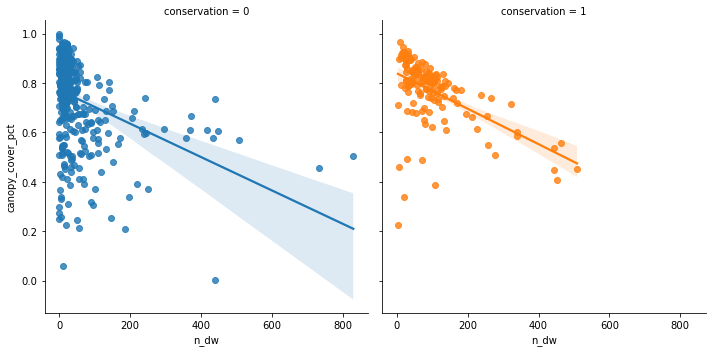

In [57]:
sns.lmplot(data=spk_stands, x='n_dw', y='canopy_cover_pct', hue='conservation', col='conservation')

Aggregated `n_dw`

In [62]:
pd.pivot_table(data=spk_stands, index=['conservation'], values=['n_dw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

min         max       mean     median        std count
                  n_dw        n_dw       n_dw       n_dw       n_dw  n_dw
conservation                                                             
0             0.000000  829.979879  49.587477  21.008403  92.151259   381
1             2.796644  508.442777  97.498008  74.913860  96.153185   145
All           0.000000  829.979879  62.794753  28.616924  95.611633   526

Same for `n_udw`.

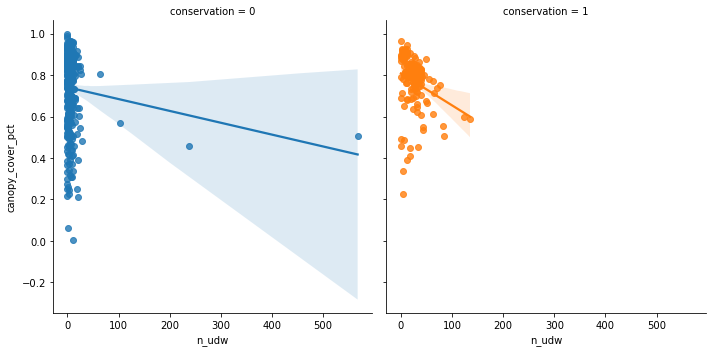

In [56]:
sns.lmplot(data=spk_stands, x='n_udw', y='canopy_cover_pct', hue='conservation', col='conservation')

Canopy cover seems not to affect standing deadwood detections.

In [63]:
pd.pivot_table(data=spk_stands, index=['conservation'], values=['n_udw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

min         max       mean     median        std count
             n_udw       n_udw      n_udw      n_udw      n_udw n_udw
conservation                                                         
0              0.0  567.404427   7.308856   3.217350  32.091234   381
1              0.0  135.045568  25.144440  23.316679  21.038580   145
All            0.0  567.404427  12.225510   5.206075  30.503394   526

Seems to be clear difference between conserved and managed forests, as mean values differ a lot.

Then `n_ddw`.

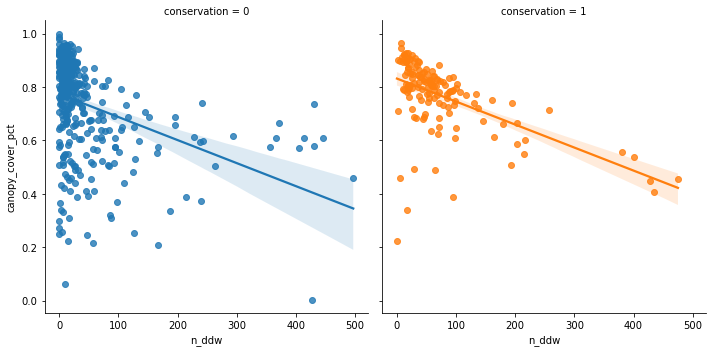

In [54]:
sns.lmplot(data=spk_stands, x='n_ddw', y='canopy_cover_pct', hue='conservation', col='conservation')

Clear-ish that denser canopy means fewer detections.

In [64]:
pd.pivot_table(data=spk_stands, index=['conservation'], values=['n_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

min         max       mean     median        std count
             n_ddw       n_ddw      n_ddw      n_ddw      n_ddw n_ddw
conservation                                                         
0              0.0  497.041420  42.278621  14.824798  77.251745   381
1              0.0  475.140713  72.353568  50.613497  83.067736   145
All            0.0  497.041420  50.569243  21.192060  79.957257   526

Conserved forests generally have more fallen deadwood instances than managed.

Then `v_ddw`.

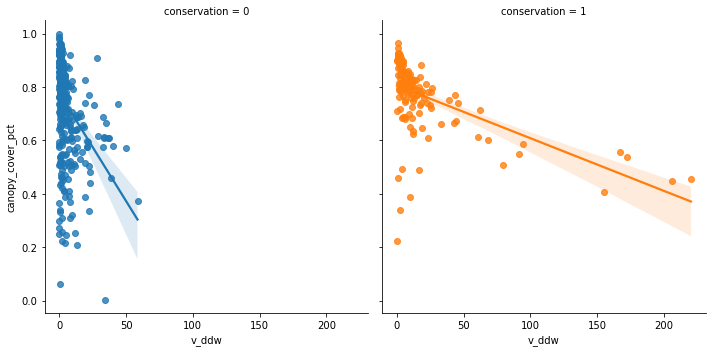

In [58]:
sns.lmplot(data=spk_stands, x='v_ddw', y='canopy_cover_pct', hue='conservation', col='conservation')

In [61]:
pd.pivot_table(data=spk_stands, index=['conservation'], values=['v_ddw'],
               aggfunc=['min', 'max', 'mean', 'median','std', 'count'], margins=True)

min         max       mean    median        std count
             v_ddw       v_ddw      v_ddw     v_ddw      v_ddw v_ddw
conservation                                                        
0              0.0   58.556061   4.860138  1.478080   8.417398   381
1              0.0  220.120678  18.284069  8.127951  35.740555   145
All            0.0  220.120678   8.560651  2.418371  20.921354   526

Difference in the estimated volume of downed deadwood per hectare between conserved and managed forests is clear.

Finally `v_ddw` and `n_ddw`:

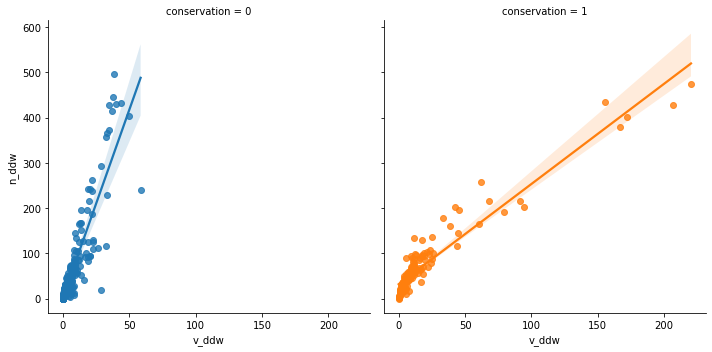

In [71]:
sns.lmplot(data=spk_stands, x='v_ddw', y='n_ddw', hue='conservation', col='conservation')

Fallen deadwood in conserved forests are clearly smaller.

In [60]:
#| echo: false
spk_stands.to_file('../../results/evo/sudenpesankangas/stand_results_new.geojson')

# Data aggregated to 16x16m grid

Some tasks, such as Zonation analyses, require data to be aggregated to 16x16m grid. First make that kind of grid.

In [8]:
from itertools import product
gridsize = 16
xmin, ymin, xmax, ymax = spk_results.total_bounds
cells = []
for x, y in tqdm(product(np.arange(xmin, xmax+gridsize, gridsize),np.arange(ymin, ymax+gridsize, gridsize))):
    x1 = x - gridsize
    y1 = y + gridsize
    cells.append(box(x,y,x1,y1))

0it [00:00, ?it/s]

Then define some functions that get the information.

In [57]:
def get_n_dw(row, trees, tree_sindex):
    nearest_idx = list(tree_sindex.nearest(row.geometry.bounds))
    tempdf = trees.iloc[nearest_idx]
    return len(tempdf[tempdf.geometry.intersects(row.geometry)])

def get_n_udw(row, trees, tree_sindex):
    nearest_idx = list(tree_sindex.nearest(row.geometry.bounds))
    tempdf = trees.iloc[nearest_idx]
    tempdf = tempdf[tempdf.layer == 'uprightwood']
    return len(tempdf[tempdf.geometry.intersects(row.geometry)])

def get_n_ddw(row, trees, tree_sindex):
    nearest_idx = list(tree_sindex.nearest(row.geometry.bounds))
    tempdf = trees.iloc[nearest_idx]
    tempdf = tempdf[tempdf.layer == 'groundwood']
    return len(tempdf[tempdf.geometry.intersects(row.geometry)])

def get_v_ddw(row, trees, tree_sindex):
    nearest_idx = list(tree_sindex.nearest(row.geometry.bounds))
    tempdf = trees.iloc[nearest_idx]
    return tempdf[tempdf.layer=='groundwood'].clip(row.geometry).v_ddw.sum()

Attach the information to grid cells.

In [43]:
grid = gpd.GeoDataFrame(cells, columns=['geometry'], crs=spk_results.crs)
trees_sindex = spk_results.sindex
grid['n_dw'] = grid.progress_apply(lambda row: get_n_dw(row, spk_results, trees_sindex), axis=1)
grid['n_udw'] = grid.progress_apply(lambda row: get_n_udw(row, spk_results, trees_sindex), axis=1)
grid['n_ddw'] = grid.progress_apply(lambda row: get_n_ddw(row, spk_results, trees_sindex), axis=1)
grid['v_ddw'] = grid.progress_apply(lambda row: get_v_ddw(row, spk_results, 
                                                          trees_sindex), axis=1)

Plot `n_dw`.

Text(0.5, 1.0, 'n_dw in 16m grid')

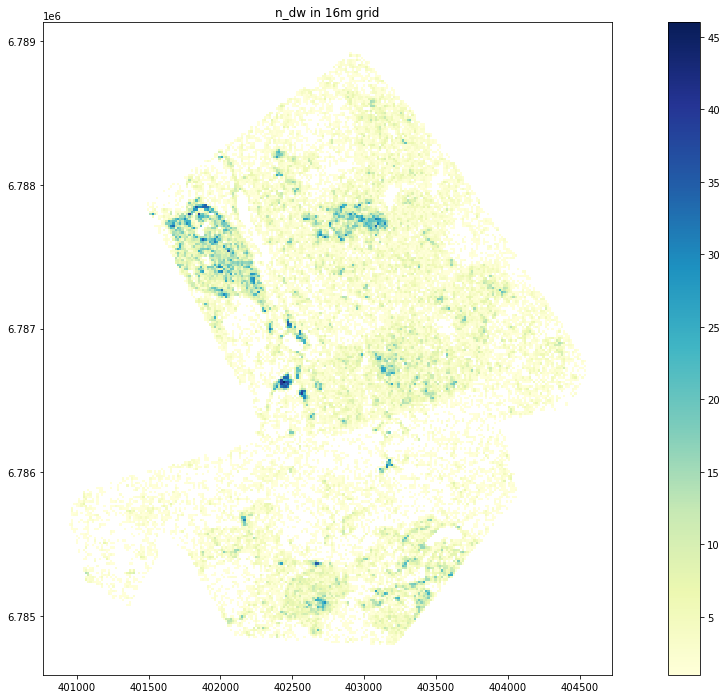

In [47]:
grid[grid.n_dw > 0].plot(column='n_dw', legend=True, figsize=(20,12), cmap='YlGnBu').set_title('n_dw in 16m grid')

Plot `n_udw`

Text(0.5, 1.0, 'n_udw in 16m grid')

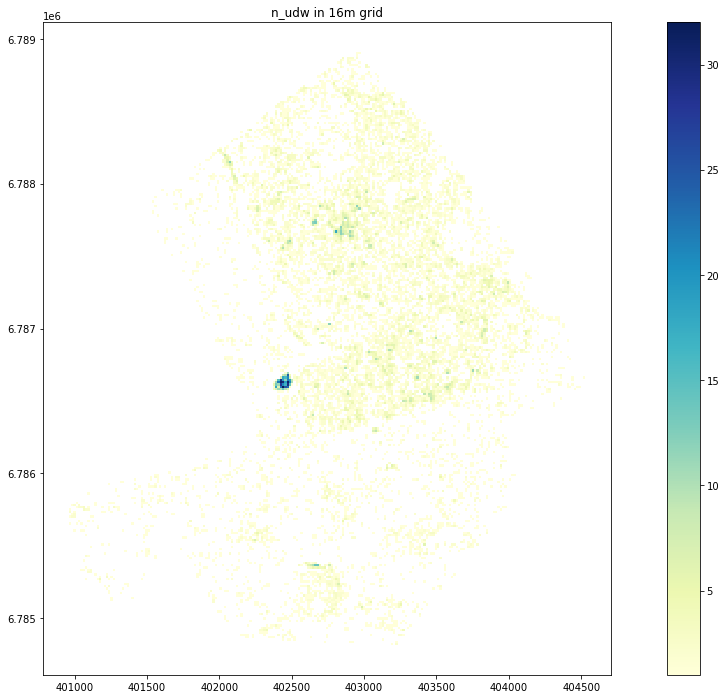

In [62]:
grid[grid.n_udw > 0].plot(column='n_udw', legend=True, figsize=(20,12), cmap='YlGnBu').set_title('n_udw in 16m grid')

Plot `n_ddw`

Text(0.5, 1.0, 'n_ddw in 16m grid')

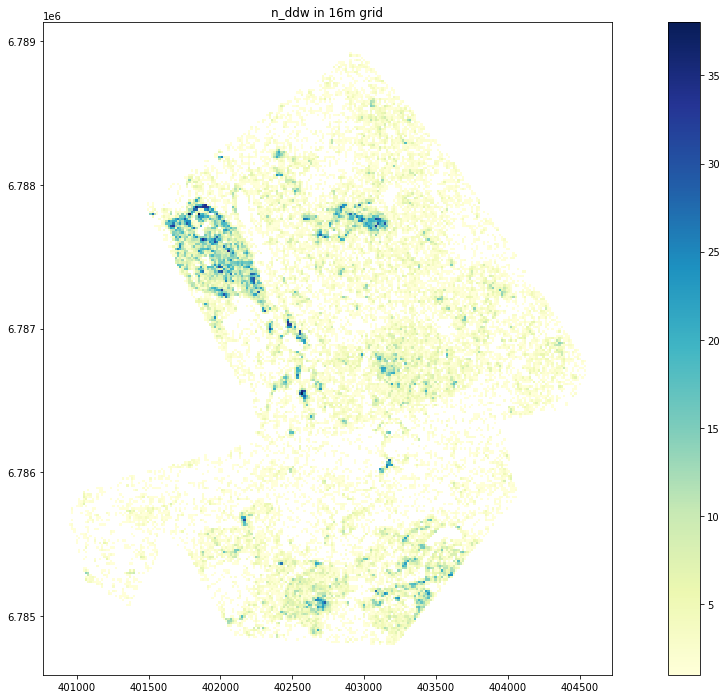

In [60]:
grid[grid.n_ddw > 0].plot(column='n_ddw', legend=True, figsize=(20,12), cmap='YlGnBu').set_title('n_ddw in 16m grid')

Plot `v_ddw`

Text(0.5, 1.0, 'v_ddw in 16m grid')

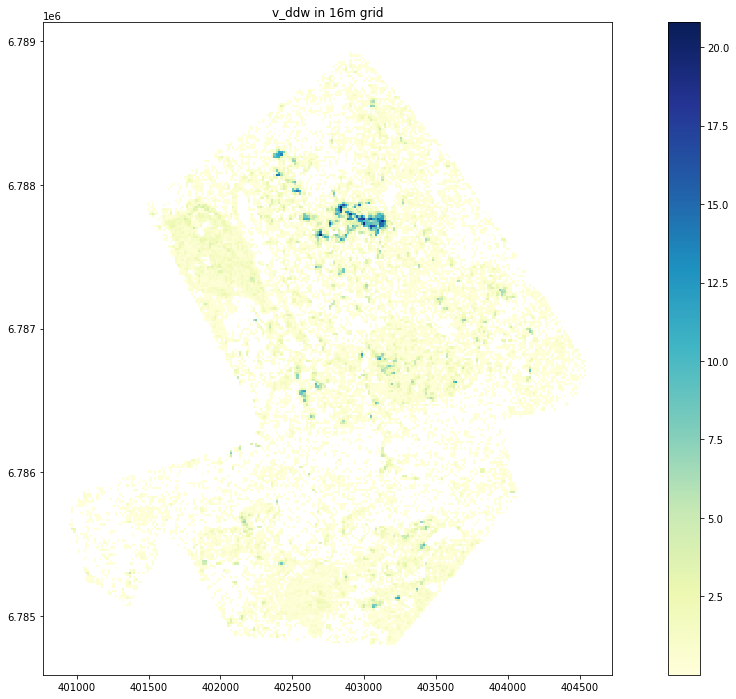

In [56]:
grid[(grid.v_ddw > 0)].plot(column='v_ddw', legend=True, figsize=(20,12), cmap='YlGnBu').set_title('v_ddw in 16m grid')